<a href="https://colab.research.google.com/github/EtikikotaHrushikesh/Automated-Helmet-and-license-plate-recognition-model/blob/master/My_custom_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a YOLOv3 Object Detector with Darknet

**Cloning and Building Darknet**

The following cells will clone darknet from AlexeyAB's famous repository, adjust the Makefile to enable OPENCV and GPU for darknet and then build darknet.

Do not worry about any warnings when you run the '!make' cell!

In [1]:
# clone darknet repo
!git clone https://github.com/AlexeyAB/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 15214, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 15214 (delta 15), reused 20 (delta 12), pack-reused 15185
Receiving objects: 100% (15214/15214), 13.65 MiB | 24.18 MiB/s, done.
Resolving deltas: 100% (10325/10325), done.


In [2]:
# change makefile to have GPU and OPENCV enabled
%cd darknet
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile

/content/darknet


In [3]:
# verify CUDA
!/usr/local/cuda/bin/nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Wed_Jul_22_19:09:09_PDT_2020
Cuda compilation tools, release 11.0, V11.0.221
Build cuda_11.0_bu.TC445_37.28845127_0


In [4]:
# make darknet (build)
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
             ^~
./src/image_

**Extra: pretrained YOLOv3 weights**

YOLOv3 has been trained already on the coco dataset which has 80 classes that it can predict. We will grab these pretrained weights so that we can run YOLOv3 on these pretrained classes and get detections.

In [ ]:
# get yolov3 pretrained coco dataset weights
!wget https://pjreddie.com/media/files/yolov3.weights

--2021-06-30 12:06:55--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  43.8MB/s    in 5.7s    

2021-06-30 12:07:01 (41.2 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]



In [5]:
# define helper functions
def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()

# use this to upload files
def upload():
  from google.colab import files
  uploaded = files.upload() 
  for name, data in uploaded.items():
    with open(name, 'wb') as f:
      f.write(data)
      print ('saved file', name)

# use this to download a file  
def download(path):
  from google.colab import files
  files.download(path)

### Connecting Google Drive
Images can also be uploaded from your Google Drive and easily have detections run on them.


Now you can run YOLOv3 with images from Google Drive using the darknet command:
```
!./darknet detect cfg/yolov3.cfg yolov3.weights /mydrive/<path to image>
```


In [6]:
%cd ..
from google.colab import drive
drive.mount('/content/gdrive')

/content
Mounted at /content/gdrive


In [7]:
# this creates a symbolic link so that now the path /content/gdrive/My\ Drive/ is equal to /mydrive
!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

 All		    d.py	   images1		   TEST
'Colab Notebooks'  'FINAL TEST'    images2		   TEST2
 detect.py	    functions.py   Motocross_preview.mp4   yolov3
 detect_video.py    images	  'My Drive'		   yolov6


##Training a Custom YOLOv3 Object Detector (Helmet and License plate detection.)


In order to create a custom YOLOv3 detector we will need the following:

*   Labeled Custom Dataset
*   Custom .cfg file
*   obj.data and obj.names files
*   train.txt file (test.txt is optional here as well)


## Moving Your Custom Dataset Into Your Cloud VM
So now that you have your dataset properly formatted to be used for training we need to move it into this cloud VM so that when it comes the time we can actually use it for training.


In [8]:
# this is where my zip is stored (I created a yolov3 folder where I will get my required files from)
!ls /mydrive/yolov3

 backup			       generate_train1.py   obj.names
 backup1		       generate_train.py   'obj(ultra fail).zip'
'backup(ultra fail)'	       obj2.zip		    obj.zip
'Copy of generate_train1.py'   obj.data		    yolov3_custom2.cfg
 custom.classes		      'obj(fail).zip'	    yolov3_custom.cfg


In [9]:
%cd /content

/content


In [10]:
# copy the .zip file into the root directory of cloud VM
!cp /mydrive/yolov3/obj.zip ./

In [11]:
# unzip the zip file and its contents should now be in /darknet/data/obj
!unzip ./obj.zip -d data/

Streaming output truncated to the last 5000 lines.
  inflating: data/obj/1165.txt       
  inflating: data/obj/1166.jpg       
  inflating: data/obj/1166.txt       
  inflating: data/obj/1167.jpg       
  inflating: data/obj/1167.txt       
  inflating: data/obj/1168.jpg       
  inflating: data/obj/1168.txt       
  inflating: data/obj/1169.jpg       
  inflating: data/obj/1169.txt       
  inflating: data/obj/117.jpg        
  inflating: data/obj/117.txt        
  inflating: data/obj/1170.jpg       
  inflating: data/obj/1170.txt       
  inflating: data/obj/1171.jpg       
  inflating: data/obj/1171.txt       
  inflating: data/obj/1172.jpg       
  inflating: data/obj/1172.txt       
  inflating: data/obj/1173.jpg       
  inflating: data/obj/1173.txt       
  inflating: data/obj/1174.jpg       
  inflating: data/obj/1174.txt       
  inflating: data/obj/1175.jpg       
  inflating: data/obj/1175.txt       
  inflating: data/obj/1176.jpg       
  inflating: data/obj/1176.txt       

In [12]:
!mv /content/data/obj /content/darknet/data

In [13]:
!mv /content/darknet/data/obj/228.jpg /content/sample_data

In [15]:
!mv /content/darknet/data/obj/1371.jpg /content/sample_data

In [14]:
!mv /content/darknet/data/obj/1371.txt /content/sample_data

In [16]:
%cd /content/darknet


/content/darknet


##Configuring the cfg file.

In [17]:
# download cfg to google drive and change its name
!cp cfg/yolov3.cfg /mydrive/yolov3/yolov3_custom2.cfg

Now you need to edit the .cfg to fit your needs based on your object detector. Open it up in a code or text editor to do so.

If you downloaded cfg to google drive you can use the built in  **Text Editor** by going to your google drive and double clicking on yolov3_custom.cfg and then clicking on the **Open with** drop down and selectin **Text Editor**.
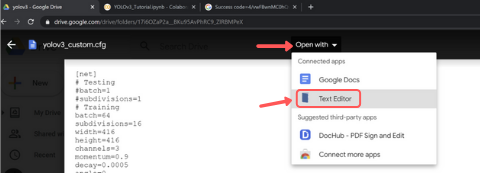

we are using **batch = 64** and **subdivisions = 16** for ultimate results. If you run into any issues then up subdivisions to 32.

Make the rest of the changes to the cfg based on how many classes you are training your detector on.

**Note:** Here we set **max_batches = 10000**, **steps = 8000, 9000**, I changed the **classes = 5** in the three YOLO layers and **filters = 30** in the three convolutional layers before the YOLO layers. 

**Optional:** In each of the three yolo layers in the cfg, change one line from random = 1 to **random = 0** to speed up training but slightly reduce accuracy of model. Will also help save memory if you run into any memory issues.


In [18]:
# upload the custom .cfg back to cloud VM from Google Drive
!cp /mydrive/yolov3/yolov3_custom.cfg /content/darknet/cfg

# upload the custom .cfg back to cloud VM from local machine (uncomment to use)
#%cd cfg
#upload()
#%cd .. 

## ii) obj.names and obj.data 
Create a new file within a code or text editor called **obj.names** and you will make this file exactly the same as your classes.txt in the dataset generation step.





In [19]:
# upload the obj.names and obj.data files to cloud VM from Google Drive
!cp /mydrive/yolov3/obj.names /content/darknet/data
!cp /mydrive/yolov3/obj.data  /content/darknet/data

# upload the obj.names and obj.data files to cloud VM from local machine (uncomment to use)
#%cd data
#upload()
#%cd .. 

## iii) Generating train.txt
The last configuration file needed before we can begin to train our custom detector is the train.txt file which hold the relative paths to all our training images.



In [20]:
# upload the generate_train.py script to cloud VM from Google Drive
!cp /mydrive/yolov3/generate_train.py ./

# upload the generate_train.py script to cloud VM from local machine (uncomment to use)
#upload()


Now we simply run the python script to do all the work for us.

In [21]:
%cd /content/darknet

/content/darknet


In [22]:
!python generate_train.py

In [23]:
# verify train.txt can be seen in our darknet/data folder
!ls /content/darknet/data

9k.tree     eagle.jpg	 imagenet.labels.list	   obj.data	     scream.jpg
coco9k.map  giraffe.jpg  imagenet.shortnames.list  obj.names	     train.txt
coco.names  goal.txt	 labels			   openimages.names  voc.names
dog.jpg     horses.jpg	 obj			   person.jpg


If everything went as planned double click on **train.txt** on the left side File Explorer and it should look like this.
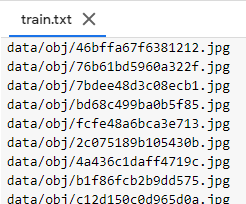

It will contain one line for each training image path.

##Download pre-trained weights for the convolutional layers.
This step downloads the weights for the convolutional layers of the YOLOv3 network. By using these weights it helps your custom object detector to be way more accurate and not have to train as long.

In [24]:
# upload pretrained convolutional layer weights
!wget http://pjreddie.com/media/files/darknet53.conv.74

--2021-07-09 08:05:14--  http://pjreddie.com/media/files/darknet53.conv.74
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://pjreddie.com/media/files/darknet53.conv.74 [following]
--2021-07-09 08:05:14--  https://pjreddie.com/media/files/darknet53.conv.74
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 162482580 (155M) [application/octet-stream]
Saving to: ‘darknet53.conv.74’

darknet53.conv.74   100%[===================>] 154.96M  43.1MB/s    in 4.0s    

2021-07-09 08:05:18 (39.2 MB/s) - ‘darknet53.conv.74’ saved [162482580/162482580]



# Train Your Custom Object Detector!

```
!./darknet detector train <path to obj.data> <path to custom config> darknet53.conv.74 -dont_show
```


In [25]:
%cd /content/darknet


/content/darknet


In [ ]:
!cp /content/darknet53.conv.74 /content/darknet

In [ ]:
# train your custom detector
!./darknet detector train /content/darknet/data/obj /content/darknet/cfg/yolov3_custom.cfg darknet53.conv.74 -dont_show


```
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show
```

In [26]:
!./darknet detector train data/obj.data cfg/yolov3_custom.cfg /mydrive/yolov3/backup/yolov3_custom_last.weights -dont_show

Streaming output truncated to the last 5000 lines.
 total_bbox = 105772, rewritten_bbox = 0.173014 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.916539), count: 2, class_loss = 0.027528, iou_loss = 0.031719, total_loss = 0.059247 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.768607), count: 3, class_loss = 0.122238, iou_loss = 0.260141, total_loss = 0.382380 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 106 Avg (IOU: 0.702526), count: 2, class_loss = 0.236567, iou_loss = 0.113348, total_loss = 0.349915 
 total_bbox = 105779, rewritten_bbox = 0.173002 % 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 82 Avg (IOU: 0.795167), count: 1, class_loss = 0.142595, iou_loss = 0.022043, total_loss = 0.164639 
v3 (mse loss, Normalizer: (iou: 0.75, obj: 1.00, cls: 1.00) Region 94 Avg (IOU: 0.760273), count: 10, class_loss = 1.017080, iou_loss = 0.466097, total_loss = 1.483177 
v3 (m

## Run Your Custom Object Detector!!!


In [27]:
# need to set our custom cfg to test mode 
%cd cfg
!sed -i 's/batch=64/batch=1/' yolov3_custom.cfg
!sed -i 's/subdivisions=16/subdivisions=1/' yolov3_custom.cfg
%cd ..


/content/darknet/cfg
/content/darknet


 CUDA-version: 11000 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 750, cudnn_half = 0, GPU: Tesla T4 
net.optimized_memory = 0 
mini_batch = 1, batch = 1, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  32 0.299 BF
   1 conv     64       3 x 3/ 2    416 x 416 x  32 ->  208 x 208 x  64 1.595 BF
   2 conv     32       1 x 1/ 1    208 x 208 x  64 ->  208 x 208 x  32 0.177 BF
   3 conv     64       3 x 3/ 1    208 x 208 x  32 ->  208 x 208 x  64 1.595 BF
   4 Shortcut Layer: 1,  wt = 0, wn = 0, outputs: 208 x 208 x  64 0.003 BF
   5 conv    128       3 x 3/ 2    208 x 208 x  64 ->  104 x 104 x 128 1.595 BF
   6 conv     64       1 x 1/ 1    104 x 104 x 128 ->  104 x 104 x  64 0.177 BF
   7 conv    128       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x 128 1.595 BF
   8 Shortcut Layer: 5,  

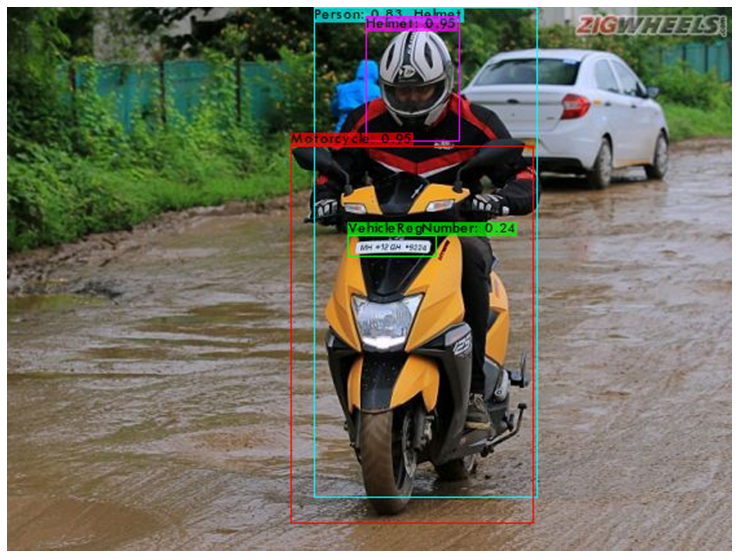

In [48]:
# run your custom detector with this command (upload an image to your google drive to test, thresh flag sets accuracy that detection must be in order to show it)
!./darknet detector test data/obj.data cfg/yolov3_custom.cfg /content/gdrive/MyDrive/yolov3/backup/yolov3_custom_last.weights /content/gdrive/MyDrive/TEST2/test8.jpg -thresh 0.1
imShow('/content/darknet/predictions.jpg')